In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os
from helper import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.decomposition import PCA
import datetime

In [2]:
data_folder = 'dataset/'
categories_list = ['isFraud']+['id_'+str(x) for x in range(12,39)]+['DeviceInfo','DeviceType','R_emaildomain','P_emaildomain','addr1','addr2','ProductCD'] + ['M'+str(x) for x in range(1,10)] + ['card'+str(x) for x in range(1,7)]+['Hours']

The below code snippet imports the dataset saved in pickle format if it exists, otherwise it imports from the csv files, reduces the memory allocation and saves it into pickle for next use

In [3]:
test_f = data_folder+'test.pkl'
train_f = data_folder+'train.pkl'

if os.path.isfile(train_f):
    train = pd.read_pickle(data_folder+'train.pkl')
else:    
    train_transaction = pd.read_csv(data_folder+'train_transaction.csv')
    train_identity = pd.read_csv(data_folder+'train_identity.csv')
    train = reduce_memory_usage(train_transaction.merge(train_identity, how='left', left_index=True, right_index=True, on='TransactionID'), categories=categories_list)
    train.to_pickle(data_folder+'train.pkl')
    del train_identity, train_transaction
    
if os.path.isfile(test_f):
    test = pd.read_pickle(data_folder+'test.pkl')
else:
    test_transaction = pd.read_csv(data_folder+'test_transaction.csv')
    test_identity = pd.read_csv(data_folder+'test_identity.csv')
    test = reduce_memory_usage(test_transaction.merge(test_identity, how='left', left_index=True, right_index=True, on='TransactionID'),categories=categories_list)
    test.to_pickle(data_folder+'test.pkl')
    del test_identity, test_transaction

In [4]:
# So as to avoid making mistakes in the main copy
Ttrain = train.copy()
Ttest = test.copy()

In [5]:
train_target = pd.DataFrame()
test_target = pd.DataFrame()

In [6]:
# converting  the date into hours (since the dates of training and test set dont match, and also some other submissions show a relation between 
# hour of transaction and % fraud)
START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
Ttrain['Date'] = Ttrain['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
Ttest['Date'] = Ttest['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
Ttrain['Hours'] = assign_category(Ttrain['Date'].dt.hour)
Ttest['Hours'] = assign_category(Ttest['Date'].dt.hour)

In [7]:
test_tran_id = Ttest['TransactionID'][0]

In [8]:
full_ds = pd.concat([Ttrain.drop(['isFraud'],axis=1),Ttest], axis=0, join='outer', ignore_index=False, keys=None, levels=None, names=None, verify_integrity=False, copy=True).reset_index(drop=True)

In [9]:
full_ds['logTAmt'] = np.log(full_ds['TransactionAmt'])
full_ds['NrmTAmt'] = full_ds['logTAmt']-full_ds['logTAmt'].mean()

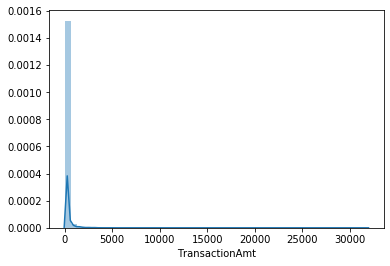

In [10]:
sns.distplot(full_ds['TransactionAmt'])
# transaction amount is badly distributed

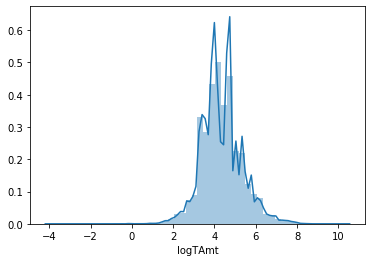

In [11]:
sns.distplot(full_ds['logTAmt'])
# the logarithm is well distributed

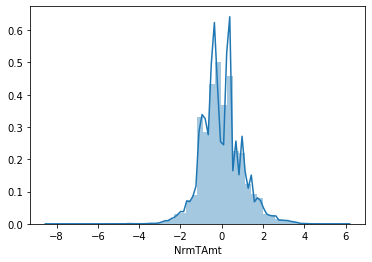

In [12]:
sns.distplot(full_ds['NrmTAmt'])
# mean is now shifted

In [13]:
categories = categories_list[1:] # all categories except 'isFraud'
category_means={}

for elem in categories:
    category_means[elem] = calc_group_mean(df=full_ds,group_of=elem,mean_of='NrmTAmt') # calculate groupwise mean of NrmTAmt

In [14]:
for elem in categories: # subtract groupwise mean from NrmTAmt 
    full_ds[elem] = full_ds['NrmTAmt']-map_to_groups(df=full_ds,group_of=elem,map_dict=category_means[elem],convert_type=np.float32)

In [15]:
summarize(full_ds[['card5']])

Dataset Shape: (1097231, 1)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,card5,float32,0,65270,-0.317914,-1.355076,-0.11831,10.56


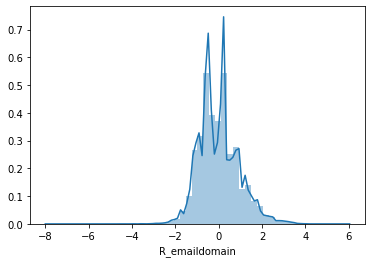

In [16]:
sns.distplot(full_ds['R_emaildomain'])

In [17]:
non_categories_C = ['C'+str(i) for i in range(1,15)]
non_categories_D = ['D'+str(i) for i in range(1,16)]
non_categories_V = ['V'+str(i) for i in range(1,340)]
non_categories_id = ['id_0'+str(i) for i in range(1,10)]+['id_10','id_11']
continuous = non_categories_C+non_categories_D+non_categories_V+non_categories_id

Dataset Shape: (1097231, 379)


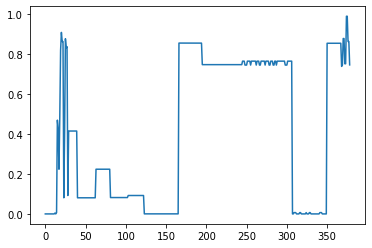

In [18]:
continuous_summary = summarize(full_ds[continuous])
plt.plot(continuous_summary['Missing']/full_ds.shape[0])
# below is a plot of % missing values, I chose to ignore the columns with more than 70% missing values

In [19]:
considered_cont, nonconsidered_cont = ignore_categories_nan(threshold=0.7,df=Ttrain,categories=continuous)

In [20]:
considered_cont_df, min_max_dct = min_max_scale(df=full_ds,categories=considered_cont) # the continuous values are scaled

In [21]:
considered_cont_df.isnull().sum().sum() # so many missing numbers in the dataset

17996183

In [22]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(considered_cont_df) # simple imputer is used to fill in the missing values

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0)

In [23]:
imputed_cont_df = pd.DataFrame(imputer.transform(considered_cont_df),columns=considered_cont)

In [24]:
n_components = 100 # PCA is used to convert continuous columns into 100 dimensions
new_sols = ['cont'+str(i) for i in range(n_components)]
pca_cont = PCA(n_components=n_components)
pca_cont.fit(imputed_cont_df)
new_cont = pd.DataFrame(pca_cont.transform(imputed_cont_df),columns = new_sols)

In [25]:
scaled_continuous,_ = min_max_scale(df=new_cont,categories=new_sols)
scaled_categorical,_ = min_max_scale(df=full_ds,categories=categories+['NrmTAmt'])

In [31]:
full_ds_scaled = scaled_categorical.merge(scaled_continuous,how='left',left_index=True, right_index=True)
train_size = Ttrain.shape
train_target = full_ds_scaled[0:train_size[0]]
test_target = full_ds_scaled[train_size[0]:]

In [27]:

#train_target, test_target = new_cont[0:train_size[0]],new_cont[train_size[0]:]

In [28]:
#train_target = train_target.merge(full_ds.loc[0:train_size[0],categories],how='left', left_index=True, right_index=True)
#test_target = test_target.merge(full_ds.loc[train_size[0]:,categories],how='left', left_index=True, right_index=True)
#train_target['NrmTAmt'] = full_ds.loc[0:train_size[0],'NrmTAmt']
#test_target['NrmTAmt'] = full_ds.loc[train_size[0]:,'NrmTAmt']

In [29]:
training_labels = Ttrain['isFraud']

A linear Regressor with 10 folds is used. But as seen with 400 iterations, one achieves .85 score

In [32]:
model = LogisticRegression(random_state = 42, solver='newton-cg', multi_class='multinomial', max_iter=400)
model, scores_valid, y_preds = Kfold_classifier(X=train_target, y = training_labels, X_test=test_target, n_folds = 10, model = model)

Beginning fold 1
Validation score after  1  th fold:  0.9669793748094964
Beginning fold 2
Validation score after  2  th fold:  0.9671825786568226
Beginning fold 3
Validation score after  3  th fold:  0.9679276594303519
Beginning fold 4
Validation score after  4  th fold:  0.9687574084736005
Beginning fold 5
Validation score after  5  th fold:  0.9673857825041488
Beginning fold 6
Validation score after  6  th fold:  0.9685203373183866
Beginning fold 7
Validation score after  7  th fold:  0.9679615267382395
Beginning fold 8
Validation score after  8  th fold:  0.9684526027026111
Beginning fold 9
Validation score after  9  th fold:  0.968469536356555
Beginning fold 10
Validation score after  10  th fold:  0.9676059200054188


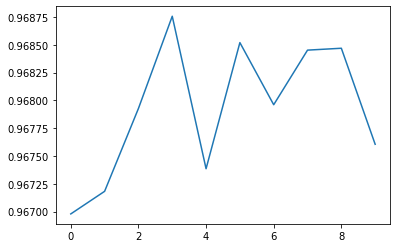

In [37]:
plt.plot(scores_valid)

In [43]:
sol_reg = pd.DataFrame()
sol_reg['TransactionID'] = Ttest['TransactionID']
sol_reg['isFraud'] = y_preds[-1][:,1]
sol_reg.to_csv(data_folder+'reg_last.csv',index=False)

![regression score 0.8531](dataset/reg-last.PNG)
The Linear regressor gives a score of 0.8531